In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-12-14 16:21:41.502794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Opening BSCCM
Opened BSCCM


In [5]:
channel_names = ['Brightfield', 'DPC_Right', 'LED119' ]
edge_crop = 32
num_images = 5000
num_patches = 5000
photons_per_pixel = 50
num_bootstrap_samples = 1
confidence_interval = 99
patch_size = 30

mi_means = []
mi_confidences = []
h_y_given_x_means = []
h_y_given_x_confidences = []
for channel_name in tqdm(channel_names):
    images = load_bsccm_images(bsccm, channel_name, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False, verbose=False, batch=1)
    patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, verbose=False)
    # patches = patches * photons_per_pixel / np.mean(images)
    # noisy_patches = add_noise(patches)

    rescale_fraction = photons_per_pixel / np.mean(images)
    noisy_patches = add_shot_noise_to_experimenal_data(patches, photon_fraction=rescale_fraction)

    mi_mean, mi_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, 
                estimation_fn=lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=False), verbose=True)
    
    h_y_given_x_mean, h_y_given_x_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval,
                estimation_fn=lambda noisy_images: estimate_conditional_entropy(noisy_images), verbose=True)

    mi_means.append(mi_mean)
    mi_confidences.append(mi_confidence)
    h_y_given_x_means.append(h_y_given_x_mean)
    h_y_given_x_confidences.append(h_y_given_x_confidence)

    
mi_means = np.array(mi_means)
mi_confidences = np.array(mi_confidences)
h_y_given_x_means = np.array(h_y_given_x_means)
h_y_given_x_confidences = np.array(h_y_given_x_confidences)

100%|██████████| 3/3 [06:13<00:00, 124.57s/it]


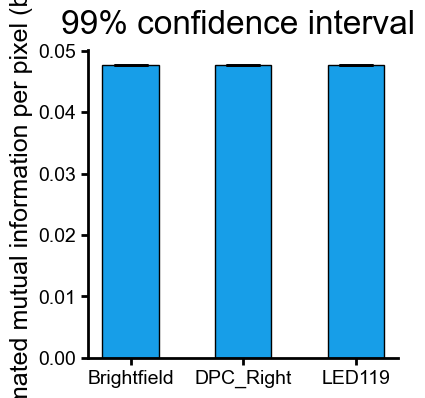

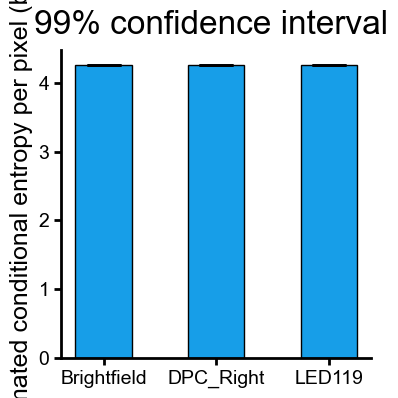

In [3]:
# set the width of the bars
bar_width = 0.35
error_kw = {'capsize': 12, 'capthick': 2}

# create a paired bar plot of results
fig, ax = plt.subplots(1, 1, figsize=(4, 4))


# create the bar plots
bar_width = 0.5
lower_errors = mi_means - mi_confidences[:, 0]
upper_errors = mi_confidences[:, 1] - mi_means

# Calculate the positions where the bars should be placed to be centered on the ticks
positions = np.arange(len(channel_names)) + 0.5 * bar_width

ax.bar(
    positions,
    mi_means,
    yerr=np.array([lower_errors, upper_errors]),
    width=bar_width,
    color=colors[0],
    edgecolor='k',
    linewidth=1,
    error_kw=error_kw
)

# add labels, title, and legend
ax.set_xticks(np.arange(len(channel_names)) + bar_width / 2, channel_names)
ax.set_ylabel('Estimated mutual information per pixel (bits)')
fig.suptitle(f'{confidence_interval}% confidence interval')
clear_spines(ax)

# make another plot for conditional entropy
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

lower_errors = h_y_given_x_means - h_y_given_x_confidences[:, 0]
upper_errors = h_y_given_x_confidences[:, 1] - h_y_given_x_means

ax.bar(
    positions,
    h_y_given_x_means,
    yerr=np.array([lower_errors, upper_errors]),
    width=bar_width,
    color=colors[0],
    edgecolor='k',
    linewidth=1,
    error_kw=error_kw
)

# add labels, title, and legend
ax.set_xticks(np.arange(len(channel_names)) + bar_width / 2, channel_names)
ax.set_ylabel('Estimated conditional entropy per pixel (bits)')
fig.suptitle(f'{confidence_interval}% confidence interval')
clear_spines(ax)

## MI vs num photons

In [4]:
channel_names = ['Brightfield', 'DPC_Right', 'LED119' ]
edge_crop = 32
num_images = 5000
num_patches = 5000
photons_per_pixel = [20, 40, 80, 160, 300]
num_bootstrap_samples = 10
confidence_interval = 99
patch_size = 20

mi_means_by_channel_photons = {}
mi_confidences_by_channel_photons = {}
for channel_name in tqdm(channel_names):
    mi_means_by_channel_photons[channel_name] = []
    mi_confidences_by_channel_photons[channel_name] = []
    images = load_bsccm_images(bsccm, channel_name, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=True, verbose=False, batch=1)
    for num_photons in photons_per_pixel:
        patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, verbose=False)
        # noisy_patches = add_shot_noise_to_experimenal_data(patches, num_photons / np.mean(images))
        noisy_patches = add_noise(patches * num_photons / np.mean(images))

        mi_mean, mi_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, 
                    estimation_fn=lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=False, use_iterative_optimization=True),
                      verbose=True)
        mi_means_by_channel_photons[channel_name].append(mi_mean)
        mi_confidences_by_channel_photons[channel_name].append(mi_confidence)
    
mi_means_by_channel_photons = {channel: np.array(v) for channel, v in mi_means_by_channel_photons.items()}
mi_confidences_by_channel_photons = {channel: np.array(v) for channel, v in mi_confidences_by_channel_photons.items()}

Running bootstraps:   0%|                                            | 0/10 [00:00<?, ?it/s]

key [2190584864 1423786288] 



/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:211: UserWarning: Mean pixel value is 19.77. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"

Running bootstraps:  10%|███▌                                | 1/10 [00:38<05:48, 38.68s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:211: UserWarning: Mean pixel value is 19.76. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"


key [3380453435 3194845310] 




Running bootstraps:  20%|███████▏                            | 2/10 [01:08<04:26, 33.25s/it]

key [1178884483 2217818671] 




Running bootstraps:  30%|██████████▊                         | 3/10 [01:36<03:36, 30.91s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:211: UserWarning: Mean pixel value is 19.75. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"


key [4026364801 1549660235] 




Running bootstraps:  40%|██████████████▍                     | 4/10 [02:10<03:13, 32.29s/it]

key [1145493063 3265275861] 




Running bootstraps:  50%|██████████████████                  | 5/10 [02:40<02:36, 31.24s/it]

key [1248459358 3138548554] 




Running bootstraps:  60%|█████████████████████▌              | 6/10 [03:06<01:58, 29.64s/it]

key [1115165421 1404801660] 




Running bootstraps:  70%|█████████████████████████▏          | 7/10 [03:32<01:25, 28.51s/it]

key [2055827265 1074138542] 




Running bootstraps:  80%|████████████████████████████▊       | 8/10 [04:01<00:57, 28.74s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:211: UserWarning: Mean pixel value is 19.74. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"


key [3909301158 3566466470] 




Running bootstraps:  90%|████████████████████████████████▍   | 9/10 [04:35<00:30, 30.16s/it]

key [ 435561101 3944890672] 




Running bootstraps: 100%|███████████████████████████████████| 10/10 [05:07<00:00, 30.80s/it]

Running bootstraps:   0%|                                            | 0/10 [00:00<?, ?it/s]

key [2167074990 4277150544] 




Running bootstraps:  10%|███▌                                | 1/10 [00:31<04:45, 31.72s/it]

key [4252905796 3426509340] 




Running bootstraps:  20%|███████▏                            | 2/10 [01:03<04:14, 31.78s/it]

key [ 828204100 2866390130] 




Running bootstraps:  30%|██████████▊                         | 3/10 [01:33<03:36, 30.87s/it]

key [ 781121966 1071906914] 




Running bootstraps:  40%|██████████████▍                     | 4/10 [02:10<03:19, 33.21s/it]

key [ 430953796 3542174609] 




Running bootstraps:  50%|██████████████████                  | 5/10 [02:48<02:56, 35.23s/it]

key [4130496131  502806341] 




Running bootstraps:  60%|█████████████████████▌              | 6/10 [03:24<02:21, 35.42s/it]

key [4042918098 1688188290] 




Running bootstraps:  70%|█████████████████████████▏          | 7/10 [04:01<01:47, 35.93s/it]

key [3011861487 3789813597] 




Running bootstraps:  80%|████████████████████████████▊       | 8/10 [04:30<01:07, 33.66s/it]

key [  46637837 3278703700] 




Running bootstraps:  90%|████████████████████████████████▍   | 9/10 [05:04<00:33, 33.91s/it]

key [4270019043 3575259431] 




Running bootstraps: 100%|███████████████████████████████████| 10/10 [05:36<00:00, 33.64s/it]

Running bootstraps:   0%|                                            | 0/10 [00:00<?, ?it/s]

key [ 716639038 3496364749] 




Running bootstraps:  10%|███▌                                | 1/10 [00:38<05:43, 38.14s/it]

key [208780447 387705175] 




Running bootstraps:  20%|███████▏                            | 2/10 [01:10<04:37, 34.65s/it]

key [3837953281 3320032251] 




Running bootstraps:  30%|██████████▊                         | 3/10 [01:49<04:18, 36.88s/it]

key [ 267345298 1022175786] 




Running bootstraps:  40%|██████████████▍                     | 4/10 [02:30<03:49, 38.27s/it]

key [4021471678 3397528312] 




Running bootstraps:  50%|██████████████████                  | 5/10 [03:05<03:06, 37.24s/it]

key [380386768 631598034] 




Running bootstraps:  60%|█████████████████████▌              | 6/10 [03:41<02:26, 36.63s/it]

key [3772232484 2166100371] 




Running bootstraps:  70%|█████████████████████████▏          | 7/10 [04:13<01:45, 35.14s/it]

key [4159057908 1001074303] 




Running bootstraps:  80%|████████████████████████████▊       | 8/10 [04:45<01:08, 34.21s/it]

key [  72753693 1611344256] 




Running bootstraps:  90%|████████████████████████████████▍   | 9/10 [05:12<00:31, 31.94s/it]

key [ 393890028 1462944059] 




Running bootstraps: 100%|███████████████████████████████████| 10/10 [05:46<00:00, 34.63s/it]

Running bootstraps:   0%|                                            | 0/10 [00:00<?, ?it/s]

key [ 379602743 1638854118] 




Running bootstraps:  10%|███▌                                | 1/10 [00:35<05:21, 35.70s/it]

key [2902075736 4059794933] 




Running bootstraps:  20%|███████▏                            | 2/10 [01:11<04:46, 35.81s/it]

key [3427877793 3650309252] 




Running bootstraps:  30%|██████████▊                         | 3/10 [01:54<04:32, 38.88s/it]

key [ 860327407 1287124823] 




Running bootstraps:  40%|██████████████▍                     | 4/10 [02:29<03:45, 37.66s/it]

key [3005317669  815939294] 




Running bootstraps:  50%|██████████████████                  | 5/10 [02:58<02:52, 34.43s/it]

key [3943757567 1599794352] 




Running bootstraps:  60%|█████████████████████▌              | 6/10 [03:37<02:24, 36.01s/it]

key [3973618774 3463045936] 




Running bootstraps:  70%|█████████████████████████▏          | 7/10 [04:06<01:40, 33.64s/it]

key [3119885948 1668230774] 




Running bootstraps:  80%|████████████████████████████▊       | 8/10 [04:37<01:05, 32.85s/it]

key [ 375838189 1947035292] 




Running bootstraps:  90%|████████████████████████████████▍   | 9/10 [05:07<00:32, 32.08s/it]

key [2907861538 3241368314] 




Running bootstraps: 100%|███████████████████████████████████| 10/10 [05:43<00:00, 34.32s/it]

Running bootstraps:   0%|                                            | 0/10 [00:00<?, ?it/s]

key [1961071172 1348145093] 




Running bootstraps:  10%|███▌                                | 1/10 [00:50<07:37, 50.85s/it]

key [1283487883 2602957654] 




Running bootstraps:  20%|███████▏                            | 2/10 [01:45<07:04, 53.10s/it]

key [4032198736 3331520293] 




Running bootstraps:  30%|██████████▊                         | 3/10 [02:36<06:04, 52.03s/it]

key [ 430074176 1346180374] 




Running bootstraps:  40%|██████████████▍                     | 4/10 [03:24<05:03, 50.65s/it]

key [2512511343  410690261] 




Running bootstraps:  50%|██████████████████                  | 5/10 [03:57<03:40, 44.09s/it]

key [ 953545701 2870194515] 




Running bootstraps:  60%|█████████████████████▌              | 6/10 [04:44<03:00, 45.12s/it]

key [661939014 417050572] 




Running bootstraps:  70%|█████████████████████████▏          | 7/10 [05:21<02:07, 42.47s/it]

key [ 923982175 4193327460] 




Running bootstraps:  80%|████████████████████████████▊       | 8/10 [06:27<01:40, 50.04s/it]

key [ 782933894 3796777254] 




Running bootstraps:  90%|████████████████████████████████▍   | 9/10 [07:06<00:46, 46.51s/it]

key [2594047710 1996133484] 




Running bootstraps:   0%|                                            | 0/10 [00:00<?, ?it/s]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:211: UserWarning: Mean pixel value is 19.73. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"


key [1195361927 3819558077] 




Running bootstraps:  10%|███▌                                | 1/10 [00:53<08:04, 53.82s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:211: UserWarning: Mean pixel value is 19.79. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"


key [3806480831 2550192098] 




Running bootstraps:  20%|███████▏                            | 2/10 [01:47<07:08, 53.61s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:211: UserWarning: Mean pixel value is 19.77. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"


key [2744627787 2182927456] 




Running bootstraps:  30%|██████████▊                         | 3/10 [02:32<05:48, 49.72s/it]

key [336100062 289963373] 




Running bootstraps:  40%|██████████████▍                     | 4/10 [03:24<05:03, 50.53s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:211: UserWarning: Mean pixel value is 19.82. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"


key [2856597857 1590298586] 




Running bootstraps:  50%|██████████████████                  | 5/10 [04:11<04:07, 49.43s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:211: UserWarning: Mean pixel value is 19.68. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"


key [3455770998 1918885064] 




Running bootstraps:  60%|█████████████████████▌              | 6/10 [04:57<03:12, 48.09s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:211: UserWarning: Mean pixel value is 19.78. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"


key [1292636496   91724388] 




Running bootstraps:  70%|█████████████████████████▏          | 7/10 [05:54<02:33, 51.08s/it]

key [1929269542 1054383881] 




Running bootstraps:  80%|████████████████████████████▊       | 8/10 [06:44<01:41, 50.74s/it]

key [ 334845235 2167752812] 




Running bootstraps:  90%|████████████████████████████████▍   | 9/10 [07:25<00:47, 47.76s/it]

key [3543088664 4078186661] 




Running bootstraps: 100%|███████████████████████████████████| 10/10 [08:07<00:00, 48.72s/it]

Running bootstraps:   0%|                                            | 0/10 [00:00<?, ?it/s]

key [2010250682 3488634278] 




Running bootstraps:  10%|███▌                                | 1/10 [00:45<06:53, 45.90s/it]

key [4163627947 1168939237] 




Running bootstraps:  20%|███████▏                            | 2/10 [01:25<05:39, 42.44s/it]

key [3479885364 1245586717] 




Running bootstraps:  30%|██████████▊                         | 3/10 [02:18<05:29, 47.09s/it]

key [3033046507 2622888964] 




Running bootstraps:  40%|██████████████▍                     | 4/10 [03:04<04:40, 46.81s/it]

key [1775365569 3223915422] 




Running bootstraps:  50%|██████████████████                  | 5/10 [03:46<03:45, 45.06s/it]

key [3435252793 2725962724] 




Running bootstraps:  60%|█████████████████████▌              | 6/10 [04:36<03:06, 46.53s/it]

key [4131161912 2652568589] 




Running bootstraps:  70%|█████████████████████████▏          | 7/10 [05:23<02:19, 46.63s/it]

key [2918177742 3634067041] 




Running bootstraps:  80%|████████████████████████████▊       | 8/10 [06:17<01:38, 49.15s/it]

key [1122079692  923479101] 




Running bootstraps:  90%|████████████████████████████████▍   | 9/10 [06:54<00:45, 45.23s/it]

key [3436696184 2054774903] 




Running bootstraps: 100%|███████████████████████████████████| 10/10 [07:44<00:00, 46.48s/it]

Running bootstraps:   0%|                                            | 0/10 [00:00<?, ?it/s]

key [3578938284 2041152314] 




Running bootstraps:  10%|███▌                                | 1/10 [00:44<06:39, 44.42s/it]

key [1110136737  681546009] 




Running bootstraps:  20%|███████▏                            | 2/10 [01:14<04:46, 35.87s/it]

key [3656055320 4029668515] 




Running bootstraps:  30%|██████████▊                         | 3/10 [01:53<04:22, 37.54s/it]

key [ 672312161 3991515289] 




Running bootstraps:  40%|██████████████▍                     | 4/10 [02:39<04:05, 40.87s/it]

key [3247477074  117872073] 




Running bootstraps:  50%|██████████████████                  | 5/10 [03:17<03:18, 39.64s/it]

key [3201066414 2753931855] 




Running bootstraps:  60%|█████████████████████▌              | 6/10 [04:02<02:45, 41.39s/it]

key [ 491291913 1345864566] 




Running bootstraps:  70%|█████████████████████████▏          | 7/10 [04:42<02:03, 41.05s/it]

key [2184356485 1950927659] 




Running bootstraps:  80%|████████████████████████████▊       | 8/10 [05:31<01:27, 43.57s/it]

key [3957437860 3811547222] 




Running bootstraps:  90%|████████████████████████████████▍   | 9/10 [06:14<00:43, 43.41s/it]

key [ 677868983 2408554682] 




Running bootstraps: 100%|███████████████████████████████████| 10/10 [07:04<00:00, 42.46s/it]

Running bootstraps:   0%|                                            | 0/10 [00:00<?, ?it/s]

key [2244917211  383143165] 




Running bootstraps:  10%|███▌                                | 1/10 [00:45<06:51, 45.70s/it]

key [ 82831865 378584995] 




Running bootstraps:  20%|███████▏                            | 2/10 [01:38<06:40, 50.03s/it]

key [3658504974  244538505] 




Running bootstraps:  30%|██████████▊                         | 3/10 [02:24<05:35, 47.88s/it]

key [1812175259 1916682218] 




Running bootstraps:  40%|██████████████▍                     | 4/10 [03:00<04:20, 43.46s/it]

key [1118316189 1423107766] 




Running bootstraps:  50%|██████████████████                  | 5/10 [03:42<03:33, 42.66s/it]

key [2049412896 3352660423] 




Running bootstraps:  60%|█████████████████████▌              | 6/10 [04:40<03:12, 48.20s/it]

key [3470770022  814388089] 




Running bootstraps:  70%|█████████████████████████▏          | 7/10 [05:09<02:05, 41.85s/it]

key [ 262783556 1784034061] 




Running bootstraps:  80%|████████████████████████████▊       | 8/10 [05:59<01:28, 44.25s/it]

key [1907558181 1492938038] 




Running bootstraps:  90%|████████████████████████████████▍   | 9/10 [06:42<00:44, 44.04s/it]

key [1661834627 1474648643] 




Running bootstraps: 100%|███████████████████████████████████| 10/10 [07:22<00:00, 44.22s/it]

Running bootstraps:   0%|                                            | 0/10 [00:00<?, ?it/s]

key [ 802440365 1474202931] 




Running bootstraps:  10%|███▌                                | 1/10 [00:47<07:03, 47.04s/it]

key [3921327878  449036812] 




Running bootstraps:  20%|███████▏                            | 2/10 [01:13<04:41, 35.13s/it]

key [3773995643 1284302401] 




Running bootstraps:  30%|██████████▊                         | 3/10 [02:04<04:56, 42.37s/it]

key [1818209701 1955357616] 




Running bootstraps:  40%|██████████████▍                     | 4/10 [02:48<04:17, 42.88s/it]

key [3155912453  160650670] 




Running bootstraps:  50%|██████████████████                  | 5/10 [03:36<03:43, 44.72s/it]

key [1587864527 3114400555] 




Running bootstraps:  60%|█████████████████████▌              | 6/10 [04:16<02:52, 43.10s/it]

key [1887014161  890962323] 




Running bootstraps:  70%|█████████████████████████▏          | 7/10 [04:46<01:56, 38.79s/it]

key [2108288038 2219240071] 




Running bootstraps:  80%|████████████████████████████▊       | 8/10 [05:29<01:20, 40.31s/it]

key [807937226 196371938] 




Running bootstraps:  90%|████████████████████████████████▍   | 9/10 [06:12<00:41, 41.14s/it]

key [2734989542  376670503] 




Running bootstraps:   0%|                                            | 0/10 [00:00<?, ?it/s]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:211: UserWarning: Mean pixel value is 19.57. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"


key [3840961916 1373422730] 




Running bootstraps:  10%|███▌                                | 1/10 [00:49<07:23, 49.31s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:211: UserWarning: Mean pixel value is 19.53. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"


key [1256983728 2661970759] 




Running bootstraps:  20%|███████▏                            | 2/10 [01:27<05:43, 42.92s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:211: UserWarning: Mean pixel value is 19.52. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"


key [1937544440 3665965159] 




Running bootstraps:  30%|██████████▊                         | 3/10 [02:14<05:11, 44.45s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:211: UserWarning: Mean pixel value is 19.50. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"


key [3199936784 3975824708] 




Running bootstraps:  40%|██████████████▍                     | 4/10 [02:55<04:19, 43.24s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:211: UserWarning: Mean pixel value is 19.58. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"


key [2896888746 2775190413] 




Running bootstraps:  50%|██████████████████                  | 5/10 [03:37<03:34, 42.95s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:211: UserWarning: Mean pixel value is 19.56. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"


key [ 658959082 1713799109] 




Running bootstraps:  60%|█████████████████████▌              | 6/10 [04:20<02:51, 43.00s/it]

key [1542655319 1477626681] 




Running bootstraps:  70%|█████████████████████████▏          | 7/10 [05:02<02:07, 42.55s/it]

key [1097437712  221114346] 




Running bootstraps:  80%|████████████████████████████▊       | 8/10 [05:34<01:18, 39.08s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:211: UserWarning: Mean pixel value is 19.54. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"


key [ 934944847 2718582678] 




Running bootstraps:  90%|████████████████████████████████▍   | 9/10 [06:25<00:42, 42.96s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:211: UserWarning: Mean pixel value is 19.64. More accurate results can probably be obtainedby setting estimate_conditional_from_model_samples=True
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. More accurate results can probably be obtained"


key [2339353479  796402069] 




Running bootstraps: 100%|███████████████████████████████████| 10/10 [07:00<00:00, 42.07s/it]

Running bootstraps:   0%|                                            | 0/10 [00:00<?, ?it/s]

key [3505324509 2747965867] 




Running bootstraps:  10%|███▌                                | 1/10 [00:45<06:49, 45.45s/it]

key [3250840239  368495852] 




Running bootstraps:  20%|███████▏                            | 2/10 [01:28<05:51, 43.89s/it]

key [ 236763159 2661608078] 




Running bootstraps:  30%|██████████▊                         | 3/10 [02:04<04:43, 40.52s/it]

key [ 990342560 2020845909] 




Running bootstraps:  40%|██████████████▍                     | 4/10 [02:58<04:34, 45.72s/it]

key [1063548294 4037068823] 




Running bootstraps:  50%|██████████████████                  | 5/10 [03:37<03:36, 43.23s/it]

key [1345337157 1737428300] 




Running bootstraps:  60%|█████████████████████▌              | 6/10 [04:28<03:04, 46.08s/it]

key [1858005998   56215269] 




Running bootstraps:  70%|█████████████████████████▏          | 7/10 [05:24<02:27, 49.05s/it]

key [1631136646 2835830601] 




Running bootstraps:  80%|████████████████████████████▊       | 8/10 [06:09<01:35, 47.95s/it]

key [2284663867 2842780016] 




Running bootstraps:  90%|████████████████████████████████▍   | 9/10 [06:54<00:47, 47.11s/it]

key [3071252116 2984909307] 




Running bootstraps: 100%|███████████████████████████████████| 10/10 [07:42<00:00, 46.25s/it]

Running bootstraps:   0%|                                            | 0/10 [00:00<?, ?it/s]

key [ 672134110 2323226642] 




Running bootstraps:  10%|███▌                                | 1/10 [00:42<06:22, 42.49s/it]

key [ 753608079 1752519382] 




Running bootstraps:  20%|███████▏                            | 2/10 [01:22<05:30, 41.32s/it]

key [4118035115  499120274] 




Running bootstraps:  30%|██████████▊                         | 3/10 [02:15<05:25, 46.54s/it]

key [1620867578 3024248638] 




Running bootstraps:  40%|██████████████▍                     | 4/10 [03:04<04:44, 47.42s/it]

key [ 36547412 987136481] 




Running bootstraps:  50%|██████████████████                  | 5/10 [03:51<03:56, 47.28s/it]

key [2315143699 2093439704] 




Running bootstraps:  60%|█████████████████████▌              | 6/10 [04:31<02:59, 44.81s/it]

key [ 766922665 3905404536] 




Running bootstraps:  70%|█████████████████████████▏          | 7/10 [05:15<02:13, 44.57s/it]

key [2810036281 1176189630] 




Running bootstraps:  80%|████████████████████████████▊       | 8/10 [05:55<01:26, 43.06s/it]

key [4050374881 2188754314] 




Running bootstraps:  90%|████████████████████████████████▍   | 9/10 [06:39<00:43, 43.31s/it]

key [2788807593 2845645635] 




Running bootstraps: 100%|███████████████████████████████████| 10/10 [07:17<00:00, 43.74s/it]

Running bootstraps:   0%|                                            | 0/10 [00:00<?, ?it/s]

key [3458108215 3196978898] 




Running bootstraps:  10%|███▌                                | 1/10 [00:32<04:51, 32.42s/it]

key [ 457617869 3192350895] 




Running bootstraps:  20%|███████▏                            | 2/10 [01:14<05:04, 38.04s/it]

key [ 367253544 2074709336] 




Running bootstraps:  30%|██████████▊                         | 3/10 [01:46<04:08, 35.44s/it]

key [3802314483 3612330169] 




Running bootstraps:  40%|██████████████▍                     | 4/10 [02:31<03:54, 39.01s/it]

key [339520880 601657401] 




Running bootstraps:  50%|██████████████████                  | 5/10 [03:06<03:07, 37.56s/it]

key [3537358580 2488938124] 




Running bootstraps:  60%|█████████████████████▌              | 6/10 [04:07<03:02, 45.51s/it]

key [2600750901 2592941781] 




Running bootstraps:  70%|█████████████████████████▏          | 7/10 [04:35<01:59, 39.85s/it]

key [3172680771 1686201260] 




Running bootstraps:  80%|████████████████████████████▊       | 8/10 [05:18<01:21, 40.99s/it]

key [4101243966  101425980] 




Running bootstraps:  90%|████████████████████████████████▍   | 9/10 [05:47<00:37, 37.08s/it]

key [1976073717 4216272598] 




Running bootstraps: 100%|███████████████████████████████████| 10/10 [06:37<00:00, 39.71s/it]

Running bootstraps:   0%|                                            | 0/10 [00:00<?, ?it/s]

key [3678153117 1623021365] 




Running bootstraps:  10%|███▌                                | 1/10 [00:43<06:35, 43.95s/it]

key [ 857392302 2667796803] 




Running bootstraps:  20%|███████▏                            | 2/10 [01:24<05:35, 41.89s/it]

key [1398110005 4031808925] 




Running bootstraps:  30%|██████████▊                         | 3/10 [02:05<04:49, 41.36s/it]

key [2456638743 3563709112] 




Running bootstraps:  40%|██████████████▍                     | 4/10 [02:49<04:14, 42.37s/it]

key [ 864274724 3456410380] 




Running bootstraps:  50%|██████████████████                  | 5/10 [03:33<03:36, 43.27s/it]

key [2978989649  405555438] 




Running bootstraps:  60%|█████████████████████▌              | 6/10 [04:20<02:56, 44.25s/it]

key [3349928372 3586181161] 




Running bootstraps:  70%|█████████████████████████▏          | 7/10 [05:04<02:13, 44.45s/it]

key [3482951695 3589218406] 




Running bootstraps:  80%|████████████████████████████▊       | 8/10 [05:48<01:28, 44.12s/it]

key [4138326808 3609659218] 




Running bootstraps:  90%|████████████████████████████████▍   | 9/10 [06:33<00:44, 44.39s/it]

key [1595428084 3196696101] 




100%|█████████████████████████████████████████████████████| 3/3 [2:17:49<00:00, 2756.62s/it]


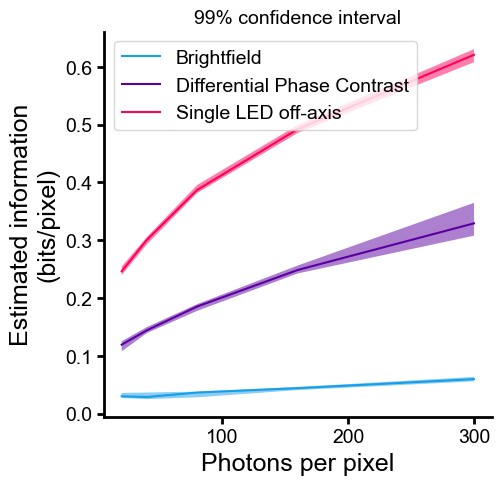

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(photons_per_pixel, mi_means_by_channel_photons['Brightfield'], label=get_display_channel_names('Brightfield'))
ax.fill_between(photons_per_pixel, mi_confidences_by_channel_photons['Brightfield'][:, 0], mi_confidences_by_channel_photons['Brightfield'][:, 1], alpha=0.5)
ax.plot(photons_per_pixel, mi_means_by_channel_photons['DPC_Right'], label=get_display_channel_names('DPC_Right'))
ax.fill_between(photons_per_pixel, mi_confidences_by_channel_photons['DPC_Right'][:, 0], mi_confidences_by_channel_photons['DPC_Right'][:, 1], alpha=0.5)
ax.plot(photons_per_pixel, mi_means_by_channel_photons['LED119'], label=get_display_channel_names('LED119'))
ax.fill_between(photons_per_pixel, mi_confidences_by_channel_photons['LED119'][:, 0], mi_confidences_by_channel_photons['LED119'][:, 1], alpha=0.5)
ax.set(xlabel='Photons per pixel', ylabel='Estimated information\n(bits/pixel)')
ax.legend()
clear_spines(ax)
ax.title.set_text(f'{confidence_interval}% confidence interval')
